# ANALYSIS ON THE VEHICLE 2430_102500

In [1]:
vehicle_code = "2430_102500"
stop = "5"

### IMPORT LIBRARIES

In [2]:
# psycopg2 is a library to execute sql queries in python
import psycopg2
# folium allows to visualize geolocalized data with the jupyter notebook
import folium
from folium.plugins import MarkerCluster
# sys is required to use the open function to write on file
import sys
# pandas is needed to read the csv file and to perform some basic operations on dataframes
import pandas as pd
# matplotlib is used to draw graphs
import matplotlib.pyplot as plt
# numpy is for scinetific computations
import numpy as np
# ST_AsGeoJSON returns a json object, so we can use json.load to parse it
import json
# scatter plot with color density
from scipy.stats import gaussian_kde

**WARNING! RUN ONLY ONCE TO SAVE THE CSV FILES!**

**YOU DON'T NEED TO CONNECT TO THE SERVER ONCE YOU ALREADY HAVE THE FILES**

### CONNECT TO THE DATASET

In [3]:
conn = psycopg2.connect("dbname=irpet", host="146.48.83.137", user="sbolgi", password="sbolgi2019", port="5435")

# the cursor allows Python code to execute PostgreSQL command in a database session.
cur = conn.cursor()

In [4]:
# First query: select all trajectories of vehicle 14710_129450
query1 = "SELECT * FROM tak.vodafone_zel1_traj_"+stop+"min WHERE vehicle = '"+ vehicle_code+"'"

# Store result in csv file to perform then other experiments
outputquery = "COPY ({0}) TO STDOUT WITH CSV HEADER".format(query1)

with open('../../../datasets/in/Traj'+stop+'min/vehicle_'+vehicle_code+'.csv', 'w', encoding='utf-8') as f:
    cur.copy_expert(outputquery, f)

In [5]:
# Store result in csv file but this time geometry is converted to coordinates

# First query: select all trajectories of vehicle 14710_129450
query1 = """
    SELECT vehicle, tid, ST_AsGeoJSON(traj) as trajcoord, company, vehicletype, length, duration, start_time, end_time
    FROM tak.vodafone_zel1_traj_"""+stop+"min WHERE vehicle = '"+ vehicle_code+"'"

# Store result in csv file to perform then other experiments
outputquery = "COPY ({0}) TO STDOUT WITH CSV HEADER".format(query1)

with open('../../../datasets/out/Traj'+stop+'min/vehicle_'+vehicle_code+'_coord.csv', 'w', encoding='utf-8') as f:
    cur.copy_expert(outputquery, f)

In [6]:
conn.close()

###### Open csv just created and execute usual statistics

In [7]:
df = pd.read_csv('../../../datasets/in/Traj'+stop+'min/vehicle_'+vehicle_code+'.csv') 

In [8]:
print("The dataset has", df.shape[0], "rows and", df.shape[1], "columns.")

The dataset has 4253 rows and 9 columns.


In [9]:
df.head(5)

,vehicle,tid,traj,company,vehicletype,length,duration,start_time,end_time
0,2430_102500,1812,01020000A0E61000005F01000088DA368C82B83440E84F...,7290,Fridge truck,94.733221,6710.69,2017-09-08 12:01:34,2017-09-08 13:53:24
1,2430_102500,9474,01020000A0E6100000020000003BFDA02E52B834405A65...,7290,Fridge truck,0.005982,38.25,2018-05-23 16:40:33,2018-05-23 16:41:11
2,2430_102500,1014,01020000A0E6100000040000008527F4FA93B83440EB02...,7290,Fridge truck,0.031537,90.93,2017-08-09 07:04:18,2017-08-09 07:05:49
3,2430_102500,1017,01020000A0E6100000040000002979758E01B93440F852...,7290,Fridge truck,0.022630,77.09,2017-08-09 09:28:21,2017-08-09 09:29:38
4,2430_102500,1107,01020000A0E6100000060000000E32C9C859B83440A390...,7290,Fridge truck,0.065960,191.20,2017-08-12 08:53:52,2017-08-12 08:57:03


In [10]:
print("the vehicle is characterized by 8 fields")
print("tid: has ", len(df["tid"].unique()), "unique values")
print("company: has ", len(df["company"].unique()), "unique values: ", df["company"].unique())
print("vehicletype: has ", len(df["vehicletype"].unique()), "unique values")

the vehicle is characterized by 8 fields
tid: has  4253 unique values
company: has  2 unique values:  ['7290' '\ufeff7290']
vehicletype: has  1 unique values


In [11]:
df[["length", "duration"]].describe()

,length,duration
count,4253.000000,4253.000000
mean,8.473771,994.796057
std,26.145616,2259.251331
min,0.000000,0.180000
25%,0.028311,153.990000
50%,0.289941,293.530000
75%,0.829860,541.440000
max,216.878553,16488.970000


the 90% of the total is  3827.7
the length of the 90% is  18.553541109034022
the duration of the 90% is  2067.29


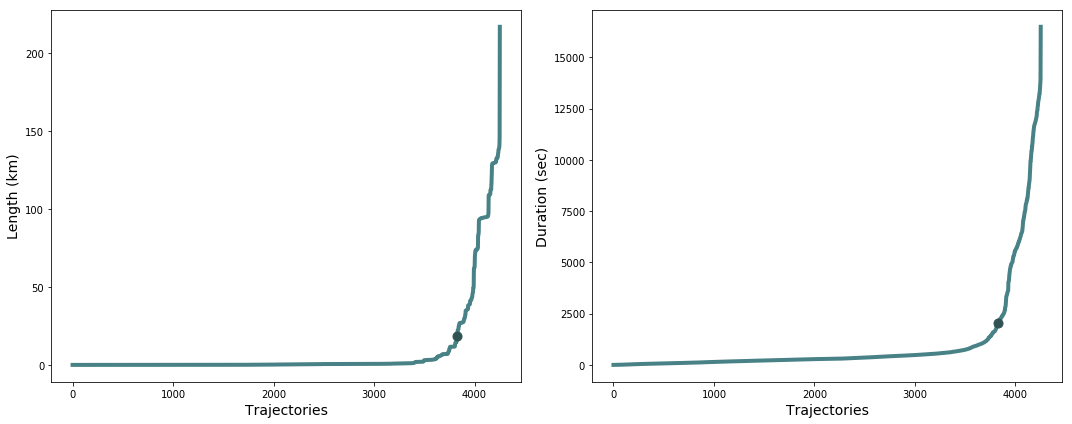

In [12]:
perc90 = (df.shape[0] * 90)/100
print("the 90% of the total is ", perc90)

perc90_i = int(perc90)

print("the length of the 90% is ", sorted(df["length"])[perc90_i])
print("the duration of the 90% is ", sorted(df["duration"])[perc90_i])

fig = plt.figure(figsize=(15, 6)) 
fig_dims = (1, 2)

ax = plt.subplot2grid(fig_dims, (0, 0))
ax.plot(range(0,df.shape[0]), sorted(df["length"]), color='#488286', linewidth=4)
plt.plot(perc90_i, sorted(df["length"])[perc90_i], 'o', color='#305252', markersize=9)
plt.xlabel("Trajectories", fontsize=14)
plt.ylabel("Length (km)", fontsize=14)

ax = plt.subplot2grid(fig_dims, (0, 1))
ax.plot(range(0,df.shape[0]), sorted(df["duration"]), color='#488286', linewidth=4)
plt.plot(perc90_i, sorted(df["duration"])[perc90_i], 'o', color='#305252', markersize=9)
plt.xlabel("Trajectories", fontsize=14)
plt.ylabel("Duration (sec)", fontsize=14)

plt.tight_layout()

plt.savefig('../../../thesis/images/Traj'+stop+'_'+vehicle_code+'_distr.png', format='png', bbox_inches='tight')

### let's zoom on the values "in the area", hence for less than 0.2 km

In [13]:
df_mini = df[df["length"] < 0.2]

The number of trajectories that lasted for less than 200 meters is 1995


C:\Users\Francesca\Anaconda3\lib\site-packages\pandas\core\series.py:942: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


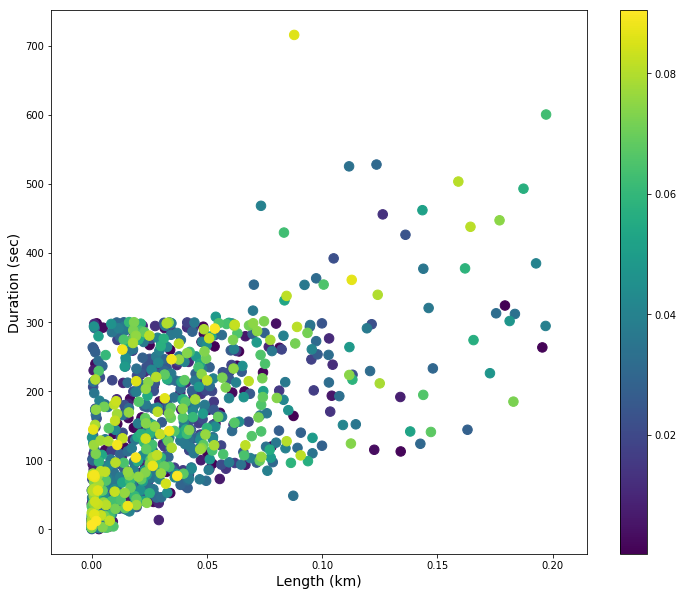

In [14]:
print("The number of trajectories that lasted for less than 200 meters is", df_mini.shape[0])

fig = plt.figure(figsize=(12, 10)) 
fig_dims = (1, 1)

x = df_mini["length"]
y = df_mini["duration"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

ax = plt.subplot2grid(fig_dims, (0, 0))
density = ax.scatter(x, y, c=z, s=90)
fig.colorbar(density)

plt.xlabel("Length (km)", fontsize=14)
plt.ylabel("Duration (sec)", fontsize=14)

plt.savefig('../../../thesis/images/Traj'+stop+'_'+vehicle_code+'_200m.png', format='png', bbox_inches='tight')

### This time we use the csv with the coordinates to try to plot them

In [15]:
df_coord = pd.read_csv('../../../datasets/out/Traj'+stop+'min/vehicle_'+vehicle_code+'_coord.csv') 

In [16]:
def swapXY(traj):
    new_traj = []
    for i in traj:
        new_traj.append([i[1], i[0]])
    return new_traj

In [17]:
coords = []

for el in  df_coord["trajcoord"]:
    y = json.loads(el)
    c = swapXY(y["coordinates"])
    coords.append(c)

In [18]:
df_coord["coord"] = coords

In [19]:
df_coord.head(5)

,vehicle,tid,trajcoord,company,vehicletype,length,duration,start_time,end_time,coord
0,2430_102500,1812,"{""type"":""LineString"",""coordinates"":[[20.720742...",7290,Fridge truck,94.733221,6710.69,2017-09-08 12:01:34,2017-09-08 13:53:24,"[[39.741511, 20.720742], [39.741623, 20.720676..."
1,2430_102500,9474,"{""type"":""LineString"",""coordinates"":[[20.720004...",7290,Fridge truck,0.005982,38.25,2018-05-23 16:40:33,2018-05-23 16:41:11,"[[39.742148, 20.720004], [39.742147, 20.719934]]"
2,2430_102500,1014,"{""type"":""LineString"",""coordinates"":[[20.721008...",7290,Fridge truck,0.031537,90.93,2017-08-09 07:04:18,2017-08-09 07:05:49,"[[39.740979, 20.721008], [39.741107, 20.720964..."
3,2430_102500,1017,"{""type"":""LineString"",""coordinates"":[[20.72268,...",7290,Fridge truck,0.022630,77.09,2017-08-09 09:28:21,2017-08-09 09:29:38,"[[39.741602, 20.72268], [39.741531, 20.722662]..."
4,2430_102500,1107,"{""type"":""LineString"",""coordinates"":[[20.72012,...",7290,Fridge truck,0.065960,191.20,2017-08-12 08:53:52,2017-08-12 08:57:03,"[[39.741679, 20.72012], [39.741681, 20.720095]..."


The majority of trajectories are not relevant. We can consider all trajectories beaneath a certain threashold just as GPS errors. In particular we consider just trajectories where the _length_ is at least 0.2 km;

In [20]:
#remove trajectories of less than 200 meters
df_long = df_coord[df_coord["length"] > 0.2]

In [21]:
print ("Of the total", df_coord.shape[0], "just", df_long.shape[0], "are trajectories are significant")

Of the total 4253 just 2258 are trajectories are significant


In [22]:
df_long = df_long.drop(columns=['trajcoord'])

In [23]:
df_long.head(5)

,vehicle,tid,company,vehicletype,length,duration,start_time,end_time,coord
0,2430_102500,1812,7290,Fridge truck,94.733221,6710.69,2017-09-08 12:01:34,2017-09-08 13:53:24,"[[39.741511, 20.720742], [39.741623, 20.720676..."
20,2430_102500,5012,7290,Fridge truck,129.512100,11750.80,2017-12-22 17:52:11,2017-12-22 21:08:02,"[[39.628675, 19.905131], [39.629765, 19.905073..."
35,2430_102500,1934,7290,Fridge truck,0.324655,464.91,2017-09-12 21:53:03,2017-09-12 22:00:48,"[[39.669949, 19.81707], [39.669959, 19.817045]..."
53,2430_102500,2045,7290,Fridge truck,0.240984,204.08,2017-09-14 22:55:44,2017-09-14 22:59:08,"[[39.670101, 19.817147], [39.670107, 19.817212..."
54,2430_102500,1018,7290,Fridge truck,0.344977,218.08,2017-08-09 09:58:58,2017-08-09 10:02:36,"[[39.741655, 20.722699], [39.741754, 20.722693..."


**The problem is that we can't draw all the trajectories together, it's a computation too heavy**

We can split it for periods of time

In [24]:
print("the first trajectory starts at", min(df_long["start_time"]))
print("the last trajectory finish at", max(df_long["start_time"]))

the first trajectory starts at 2017-07-01 09:46:16
the last trajectory finish at 2018-06-30 23:10:37


In [25]:
df_long['start_month'] = pd.DatetimeIndex(df_long['start_time']).month

In [26]:
def center_traj(coords):
    sum_x = 0
    sum_y = 0
    for i in coords:
        sum_x += i[0][0]
        sum_y += i[0][1]
    c_x = sum_x / len(coords)
    c_y = sum_y / len(coords)
    return c_x, c_y

**JULY 2017**

In [27]:
df_july = df_long[df_long["start_month"] == 7]

In [28]:
print ("in july this vehicle has", len(df_july), "significant trajectories")

in july this vehicle has 143 significant trajectories


In [29]:
coords = df_july["coord"].tolist()
c_x, c_y = center_traj(coords)

In [30]:
colors = ['gray', 'orange', 'green', 'lightred', 'darkgreen', 'darkblue', 'darkred', 'pink', 
          'lightgrayblack', 'lightblue', 'cadetblue', 'darkpurple', 'lightgreen', 'purple', 'blue', 'red', 'beige']

m = folium.Map(location=[c_x, c_y], zoom_start=8)
for i in range(len(df_july)):
    my_PolyLine=folium.PolyLine(locations=coords[i], weight=5, color=colors[i%17])
    m.add_child(my_PolyLine)
    
mc = MarkerCluster()
for i in range(len(df_july)):
    marker = folium.Marker(location=coords[i][0], popup=i, icon=folium.Icon(color=colors[i%17],icon='play'))
    mc.add_child(marker)
    
    marker = folium.Marker(location=coords[i][-1], popup=i, icon=folium.Icon(color=colors[i%17],icon='stop'))
    mc.add_child(marker)

m.add_child(mc)
m

**JANUARY 2018**

In [31]:
df_jan = df_long[df_long["start_month"] == 1]

In [32]:
print ("in november this vehicle has", len(df_jan), "significant trajectories")

in november this vehicle has 196 significant trajectories


In [33]:
coords = df_jan["coord"].tolist()
c_x, c_y = center_traj(coords)

In [34]:
colors = ['gray', 'orange', 'green', 'lightred', 'darkgreen', 'darkblue', 'darkred', 'pink', 
          'lightgrayblack', 'lightblue', 'cadetblue', 'darkpurple', 'lightgreen', 'purple', 'blue', 'red', 'beige']

m = folium.Map(location=[c_x, c_y], zoom_start=8.4)
for i in range(len(df_jan)):
    my_PolyLine=folium.PolyLine(locations=coords[i], weight=5, color=colors[i%17])
    m.add_child(my_PolyLine)
    
mc = MarkerCluster()
for i in range(len(df_jan)):
    marker = folium.Marker(location=coords[i][0], popup=i, icon=folium.Icon(color=colors[i%17],icon='play'))
    mc.add_child(marker)
    
    marker = folium.Marker(location=coords[i][-1], popup=i, icon=folium.Icon(color=colors[i%17],icon='stop'))
    mc.add_child(marker)

m.add_child(mc)
m